In [13]:
!pip install pandas-ta
!pip install yfinance

     |████████████████████████████████| 59 kB 5.4 MB/s  eta 0:00:01
     |████████████████████████████████| 502 kB 18.3 MB/s eta 0:00:01
     |████████████████████████████████| 114 kB 33.4 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 40.2 MB/s eta 0:00:01
  Using cached lxml-4.9.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (7.1 MB)
  Attempting uninstall: pytz
    Found existing installation: pytz 2021.3
    Uninstalling pytz-2021.3:
      Successfully uninstalled pytz-2021.3
  Attempting uninstall: lxml
    Found existing installation: lxml 4.8.0
    Uninstalling lxml-4.8.0:
      Successfully uninstalled lxml-4.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.1.5 requires pyqt5<5.13, which is not installed.
spyder 5.1.5 requires pyqtwebengine<5.13, which is not installed.
conda-repo-cli 1.0.4 

In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#tf.random.set_seed(20)
np.random.seed(10)

2023-03-28 16:36:58.570271: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 16:36:59.049701: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-28 16:37:00.958455: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-28 16:37:00.958726: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

#Alpha vantage

2OQT6WT9WH45WTK5

In [2]:
#df = yf.download(tickers = 'TSLA', start = '2022-03-11',end = '2023-03-11')
tickers = yf.Tickers('TSLA')

# access each ticker using (example)

data = tickers.tickers['TSLA'].history(period="4y")
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-03-28 00:00:00-04:00,18.477333,18.688667,18.340000,18.574667,101611500,0.0,0.0
2019-03-29 00:00:00-04:00,18.580000,18.677334,18.299999,18.657333,89869500,0.0,0.0
2019-04-01 00:00:00-04:00,18.841333,19.280001,18.752001,19.278667,121656000,0.0,0.0
2019-04-02 00:00:00-04:00,19.219999,19.296000,18.925333,19.058666,82183500,0.0,0.0
2019-04-03 00:00:00-04:00,19.154667,19.744667,19.144667,19.454000,118791000,0.0,0.0


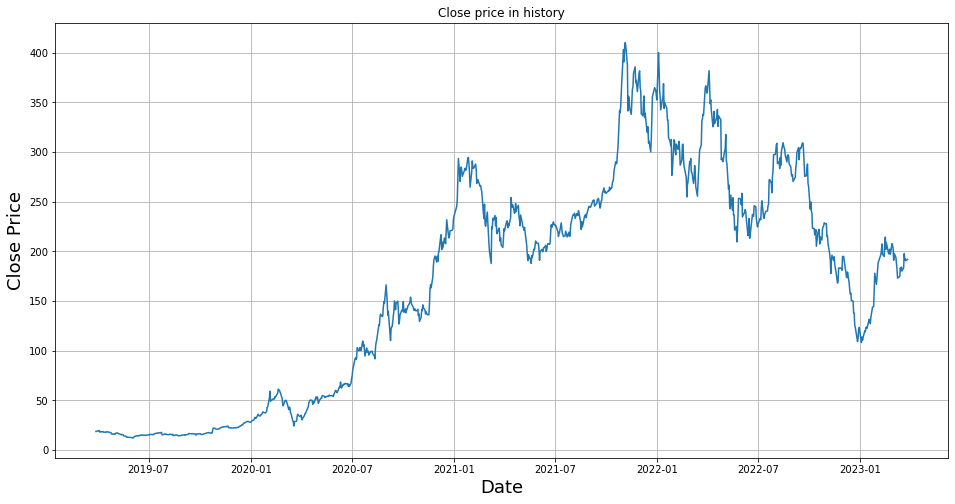

In [6]:
plt.figure(figsize = (16,8))
plt.title("Close price in history")
plt.plot(data["Close"])
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Close Price", fontsize = 18)
plt.grid()
plt.show()

In [7]:
data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=100)
data['EMAS']=ta.ema(data.Close, length=150)

data['TargetNextClose'] = data['Close'].shift(-1)
data['Target'] = data['Close']-data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Close'].shift(-1)

data.iloc[:, 0:-1].dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['Volume', 'Date'], axis=1, inplace=True)

In [8]:
data_set = data.iloc[:, 0:11]#.values
pd.set_option('display.max_columns', None)

original = data_set.copy()
data_set.tail(20)

#print(data_set.shape)
#print(data.shape)
#print(type(data_set))

,Open,High,Low,Close,Dividends,Stock Splits,RSI,EMAF,EMAM,EMAS,TargetNextClose
987,210.589996,211.229996,203.750000,205.710007,0.0,0.0,60.980688,193.427057,188.949506,202.995232,202.770004
988,206.210007,207.199997,198.520004,202.770004,0.0,0.0,59.018172,194.316861,189.223179,202.992249,190.899994
989,186.740005,193.750000,186.009995,190.899994,0.0,0.0,51.805978,193.991445,189.256383,202.832087,197.789993
990,194.800003,200.479996,192.880005,197.789993,0.0,0.0,55.210012,194.353212,189.425366,202.765304,193.809998
991,198.539993,198.600006,192.300003,193.809998,0.0,0.0,52.897609,194.301477,189.512190,202.646691,187.710007
992,191.380005,194.199997,186.100006,187.710007,0.0,0.0,49.493500,193.673718,189.476503,202.448854,182.000000
993,185.039993,186.500000,180.000000,182.000000,0.0,0.0,46.492791,192.561935,189.328454,202.178008,172.919998
994,180.250000,185.179993,172.509995,172.919998,0.0,0.0,42.139865,190.691275,189.003534,201.790485,173.440002
995,175.130005,178.289993,168.440002,173.440002,0.0,0.0,42.470365,189.048296,188.695345,201.414982,174.479996
996,167.460007,177.350006,163.910004,174.479996,0.0,0.0,43.166009,187.660839,188.413853,201.058227,183.259995


In [9]:
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)
print(data_set_scaled)

[[0.01603419 0.0155287  0.01660627 ...        nan        nan 0.01689786]
 [0.01629124 0.01550051 0.01650471 ...        nan        nan 0.01845885]
 [0.01694556 0.01699949 0.01765231 ...        nan        nan 0.01790613]
 ...
 [0.45865846 0.46477812 0.44901075 ... 0.5650689  0.62643403 0.44839531]
 [0.44961983 0.44749177 0.44520236 ... 0.56521447 0.62601889 0.45191254]
 [0.4565553  0.46000261 0.45228598 ... 0.56544789 0.62567248        nan]]


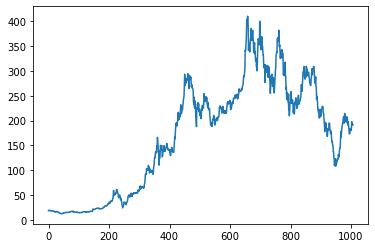

In [11]:
plt.plot(data["Close"])

In [12]:
# multiple feature from data provided to the model
X = []
backcandles = 30
print(data_set_scaled.shape[0])
for j in range(8):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):#backcandles+2
        X[j].append(data_set_scaled[i-backcandles:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))
#y=sc.fit_transform(yi)
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#print(X)
print(X.shape)
#print(y)
print(y.shape)

1007
(977, 30, 8)
(977, 1)


In [13]:
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

781
(781, 30, 8)
(196, 30, 8)
(781, 1)
(196, 1)


In [14]:
lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=200, shuffle=True, validation_split = 0.1)

2023-03-28 16:47:22.588439: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-28 16:47:22.588516: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fish): /proc/driver/nvidia/version does not exist
2023-03-28 16:47:22.589988: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
47/47 [==============================] - 9s 69ms/step - loss: nan - val_loss: nan
Epoch 2/200
47/47 [==============================] - 2s 36ms/step - loss: nan - val_loss: nan
Epoch 3/200
47/47 [==============================] - 2s 38ms/step - loss: nan - val_loss: nan
Epoch 4/200
47/47 [==============================] - 2s 40ms/step - loss: nan - val_loss: nan
Epoch 5/200
47/47 [==============================] - 2s 38ms/step - loss: nan - val_loss: nan
Epoch 6/200
47/47 [==============================] - 2s 38ms/step - loss: nan - val_loss: nan
Epoch 7/200
47/47 [==============================] - 2s 36ms/step - loss: nan - val_loss: nan
Epoch 8/200
47/47 [==============================] - 2s 38ms/step - loss: nan - val_loss: nan
Epoch 9/200
47/47 [==============================] - 2s 37ms/step - loss: nan - val_loss: nan
Epoch 10/200
47/47 [==============================] - 2s 39ms/step - loss: nan - val_loss: nan
Epoch 11/200
47/47 [==============================] - 2s 38

47/47 [==============================] - 2s 40ms/step - loss: nan - val_loss: nan
Epoch 88/200
47/47 [==============================] - 2s 39ms/step - loss: nan - val_loss: nan
Epoch 89/200
47/47 [==============================] - 2s 44ms/step - loss: nan - val_loss: nan
Epoch 90/200
47/47 [==============================] - 2s 41ms/step - loss: nan - val_loss: nan
Epoch 91/200
47/47 [==============================] - 2s 41ms/step - loss: nan - val_loss: nan
Epoch 92/200
47/47 [==============================] - 2s 38ms/step - loss: nan - val_loss: nan
Epoch 93/200
47/47 [==============================] - 2s 41ms/step - loss: nan - val_loss: nan
Epoch 94/200
47/47 [==============================] - 2s 38ms/step - loss: nan - val_loss: nan
Epoch 95/200
47/47 [==============================] - 2s 40ms/step - loss: nan - val_loss: nan
Epoch 96/200
47/47 [==============================] - 2s 39ms/step - loss: nan - val_loss: nan
Epoch 97/200
47/47 [==============================] - 2s 39ms/s

47/47 [==============================] - 2s 40ms/step - loss: nan - val_loss: nan
Epoch 173/200
47/47 [==============================] - 2s 42ms/step - loss: nan - val_loss: nan
Epoch 174/200
47/47 [==============================] - 2s 42ms/step - loss: nan - val_loss: nan
Epoch 175/200
47/47 [==============================] - 2s 42ms/step - loss: nan - val_loss: nan
Epoch 176/200
47/47 [==============================] - 2s 39ms/step - loss: nan - val_loss: nan
Epoch 177/200
47/47 [==============================] - 2s 40ms/step - loss: nan - val_loss: nan
Epoch 178/200
47/47 [==============================] - 2s 41ms/step - loss: nan - val_loss: nan
Epoch 179/200
47/47 [==============================] - 2s 39ms/step - loss: nan - val_loss: nan
Epoch 180/200
47/47 [==============================] - 2s 40ms/step - loss: nan - val_loss: nan
Epoch 181/200
47/47 [==============================] - 1s 23ms/step - loss: nan - val_loss: nan
Epoch 182/200
47/47 [==============================] -

In [15]:
y_pred = model.predict(X_test)
#y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred[i], y_test[i])

7/7 [==============================] - 1s 11ms/step
[nan] [0.50539983]
[nan] [0.51459488]
[nan] [0.56553635]
[nan] [0.56314965]
[nan] [0.56059547]
[nan] [0.58731814]
[nan] [0.58534179]
[nan] [0.55454913]
[nan] [0.54406441]
[nan] [0.53397323]


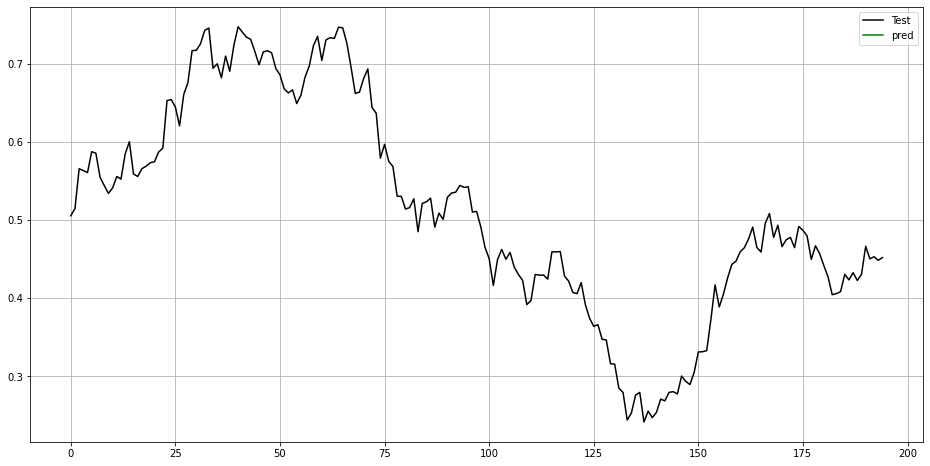

In [16]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.grid()
plt.show()